# ***塾のレッスン記録データをpythonで分析し、時間割を最適化してみました***

In [1]:
import gc
gc.collect()
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import re

# **データの下処理**  ※生徒の氏名は実名ではありません。

### 二つのcsvデータのカラム名を揃えて、一つのデータフレームに統合する。

In [2]:
#csvからデータを取得
df1 = pd.read_csv('Attendance data from 10_12-12_26.csv')
df2 = pd.read_csv('Attendance data from 06_28-10_17.csv')
print('元のデータ\ndf1↓')
display(df1.head())
print('df2↓')
display(df2.head())
#二つのデータフレームをマージするために必要なカラムの名前を揃える
df1 = df1.drop(columns = ['Unnamed: 0','レッスン内容　（例：callan 3 237-242）', '先生方へのお知らせ・メモ'])
df2 = df2.drop(columns = ['Unnamed: 0','授業内容（記入例：カラン〇　100-102)', 'Unnamed: 2', '不明・その他の場合メモ'])

#二つのデータフレームをマージ
df = df1.merge(df2,how='outer')
# df1,df2のメモリを解放
del df1,df2
#カラム名を変更
df = df.rename(columns={'タイムスタンプ':'Time','レッスン内容':'Stage','氏名':'Name'})
print('\n\n\n二つのデータフレームを統合し、整理したdf ↓')
display(df.head())

元のデータ
df1↓


,Unnamed: 0,タイムスタンプ,レッスン内容,氏名,レッスン内容 （例：callan 3 237-242）,先生方へのお知らせ・メモ
0,0,10/17/2020 10:22:28,初級,その他,テスト,NaN
1,1,10/17/2020 12:21:30,初級,"明石家さんま, ローラ",Callan4 289-295,NaN
2,2,10/17/2020 16:20:50,その他,福士蒼汰,ディクテーション,過去分詞の後置修飾の長めの文章のリスニングが苦手なようです。
3,3,10/17/2020 17:27:52,中上級,イモトアヤコ,Callan10 933-939,NaN
4,4,10/17/2020 19:03:48,中級,岡田准一,callan5 382-383,NaN


df2↓


,Unnamed: 0,タイムスタンプ,氏名,Unnamed: 2,授業内容（記入例：カラン〇 100-102),レッスン内容,不明・その他の場合メモ
0,4,6/24/2020 17:32:21,"いとうあさこ, 山田孝之",NaN,シャドーイング,その他,NaN
1,5,6/24/2020 18:02:12,"渡辺直美, いとうあさこ",NaN,Callan 3&4,中級,NaN
2,6,6/24/2020 18:27:41,山田孝之,NaN,中学英語 Whenの使い方、Whyの答え方,その他,NaN
3,7,6/24/2020 19:05:19,福山雅治,NaN,Callan 8&9 lesson 98,中上級,NaN
4,8,6/24/2020 19:30:51,"石原さとみ, 岡田准一",NaN,カラン５ p315-318,中級,りささんは本来カラン２のp97から。





二つのデータフレームを統合し、整理したdf ↓


,Time,Stage,Name
0,10/17/2020 10:22:28,初級,その他
1,10/17/2020 12:21:30,初級,"明石家さんま, ローラ"
2,10/17/2020 16:20:50,その他,福士蒼汰
3,10/17/2020 17:27:52,中上級,イモトアヤコ
4,10/17/2020 19:03:48,中級,岡田准一


### 生徒の氏名データのカラムdf['Name']を、一人一人の氏名ごとのレコードに分割する

In [3]:
df['Name'] = df['Name'].apply(lambda x: x.split(','))
df = pd.DataFrame({
    'Name':np.concatenate(df['Name'].values),
    'Stage':df['Stage'].repeat(df['Name'].str.len()),
    'Time':df['Time'].repeat(df['Name'].str.len())
})
df = df.reset_index(drop=True)

print("修正後のdf↓")
display(df.head())

修正後のdf↓


,Name,Stage,Time
0,その他,初級,10/17/2020 10:22:28
1,明石家さんま,初級,10/17/2020 12:21:30
2,ローラ,初級,10/17/2020 12:21:30
3,福士蒼汰,その他,10/17/2020 16:20:50
4,イモトアヤコ,中上級,10/17/2020 17:27:52


### df['Time']のカラムを分割し、月、日、月、分、曜日のカラムをつくる

In [4]:
df['Month'] = df['Time'].apply(lambda x: int(re.split('[/:]',x)[0]))
df['Day'] = df['Time'].apply(lambda x: int(re.split('[/:]',x)[1]))
df['Hour'] = df['Time'].apply(lambda x: int(re.split('[/:]',x)[2][-2:]))
df['Min'] = df['Time'].apply(lambda x: int(re.split('[/:]',x)[3]))
#df['Time']を削除
df = df.drop('Time',axis = 1)
#外れ値を除く
df = df[df['Month']!=2020]

#月日をもとに曜日のカラムを作成（月：0、火:1、...、日:6）
import datetime
import locale
df['Day of Week'] = '0'
datetime.datetime(2020, 1, 1).strftime('%a')

def get_day_of_week(x):
    y = datetime.datetime(2020, x['Month'], x['Day']).strftime('%a')
    if y=='Mon': return 0
    elif y=='Tue': return 1
    elif y=='Wed': return 2
    elif y=='Thu': return 3
    elif y=='Fri': return 4
    elif y=='Sat': return 5
    elif y=='Sun': return 6
    else: return 100

df['Day of Week'] = df.apply(get_day_of_week,axis=1)    

print("修正後のdf↓")
display(df.head())

修正後のdf↓


,Name,Stage,Month,Day,Hour,Min,Day of Week
0,その他,初級,10,17,10,22,5
1,明石家さんま,初級,10,17,12,21,5
2,ローラ,初級,10,17,12,21,5
3,福士蒼汰,その他,10,17,16,20,5
4,イモトアヤコ,中上級,10,17,17,27,5


### df['Hour'],df['Min']のデータをもとに、それが何コマ目のレッスンだったかを表すカラムdf['Time Zone']を作成

In [5]:
def define_time_zone(x):
        if (x['Hour']==10 or (x['Hour']==11 and x['Min']<=15)): return 0
        elif (((x['Hour']==11 and 15<x['Min']<=59)) or (x['Hour']==12 and x['Min']<=59)): return 1
        elif (((x['Hour']==13) or (x['Hour']==14 and x['Min']<=45))): return 2
        elif (((x['Hour']==14 and 45<x['Min']<=59)) or (x['Hour']==15 and x['Min']<=45)): return 3
        elif (((x['Hour']==15 and 45<x['Min']<=59)) or (x['Hour']==16 and x['Min']<=45)): return 4
        elif (((x['Hour']==16 and 45<x['Min']<=59)) or (x['Hour']==17 and x['Min']<=45)): return 5
        elif (((x['Hour']==17 and 45<x['Min']<=59)) or (x['Hour']==18 and x['Min']<=45)): return 6
        elif (((x['Hour']==18 and 45<x['Min']<=59)) or (x['Hour']==19 and x['Min']<=45)): return 7
        elif (((x['Hour']==19 and 45<x['Min']<=59)) or (x['Hour']==20 and x['Min']<=59)): return 8
        else: return 100

df['Time Zone'] = df.apply(define_time_zone,axis=1)
df = df[df['Time Zone']!=100]

#もう使わないカラムを削除
df = df.drop(['Hour','Min'],axis = 1)

#10月以降のデータのみ使用する
df = df[10<=df['Month']]

print("修正後のdf↓")
display(df.head())

修正後のdf↓


,Name,Stage,Month,Day,Day of Week,Time Zone
0,その他,初級,10,17,5,0
1,明石家さんま,初級,10,17,5,1
2,ローラ,初級,10,17,5,1
3,福士蒼汰,その他,10,17,5,4
4,イモトアヤコ,中上級,10,17,5,5


In [14]:

len(sorted(df['Name'].unique()))

31

### 生徒の名前に応じて割り当てる'Name Label'のカラムを作成

In [15]:
def define_name_label(x):
        if x['Name']=='いとうあさこ'       : return 0
        elif x['Name']=='イチロー'       : return 1
        elif x['Name']=='イモトアヤコ'       : return 2
        elif x['Name']=='サンドウィッチマン': return 3
        elif x['Name']=='タモリ'       : return 4
        elif x['Name']=='マツコ・デラックス'      : return 5
        elif x['Name']=='ローラ'       : return 6
        elif x['Name']=='上戸彩'    : return 7
        elif x['Name']=='出川哲郎'      : return 8
        elif x['Name']=='北川景子'     : return 9
        elif x['Name']=='博多華丸・大吉'     : return 10
        elif x['Name']=='吉田羊'      : return 11
        elif x['Name']=='大泉洋'  : return 12
        elif x['Name']=='天海祐希': return 13
        elif x['Name']=='宇多田ヒカル': return 14
        elif x['Name']=='山田孝之': return 15
        elif x['Name']=='岡田准一': return 16
        elif x['Name']=='所ジョージ': return 17
        elif x['Name']=='明石家さんま': return 18
        elif x['Name']== '浅田真央': return 19
        elif x['Name']=='深田恭子': return 20
        elif x['Name']=='渡辺直美': return 21
        elif x['Name']=='相葉雅紀': return 22
        elif x['Name']== '石原さとみ': return 23
        elif x['Name']=='石田ゆり子': return 24
        elif x['Name']== '福士蒼汰': return 25
        elif x['Name']=='福山雅治': return 26
        elif x['Name']=='米倉涼子': return 27
        elif x['Name']=='綾瀬はるか': return 28
        elif x['Name']=='阿部サダヲ': return 29
        elif x['Name']=='阿部寛': return 30
        else: return 100

#生徒の名前に含まれている空白を埋める
df['Name'] = df['Name'].apply(lambda x: x.strip())
#外れ値を除く
df = df[df['Name']!='その他']
df = df[df['Name']!='テスト']

#生徒の名前に応じて割り当てる'Name Label'のカラムを作成
df.insert(0, 'Name Label', 0)
df['Name Label'] = df.apply(define_name_label,axis = 1)
print("修正後のdf↓")
display(df.head())

修正後のdf↓


,Name Label,Name,Stage,Month,Day,Day of Week,Time Zone
1,18,明石家さんま,初級,10,17,5,1
2,6,ローラ,初級,10,17,5,1
3,25,福士蒼汰,その他,10,17,5,4
4,2,イモトアヤコ,中上級,10,17,5,5
5,16,岡田准一,中級,10,17,5,7


### df['Stage']において、'初級'のなかでも3コマ目のレッスンは'初めて英語'、それ以外は'初級'として区別

### 初めて英語→０、初級→１、中級→２、中上級→３　に変更する

In [16]:
def define_stage(x):
    if (x['Stage'] == '初級'):
        if (x['Time Zone'] == 2):return 0
        else: return 1
    elif (x['Stage'] == '中級'): return 2
    elif (x['Stage'] == '中上級'):return 3
    else : return 100

df['Stage'] = df.apply(define_stage,axis=1)
#その他レッスンを削除
df = df[df['Stage']!=100]
df = df.reset_index(drop=True)

# csvファイルで保存 index=Falseでindexをカラムとして保存しない
df.to_csv('Data_Set.csv')

print("修正後のdf↓")
display(df.head())

修正後のdf↓


,Name Label,Name,Stage,Month,Day,Day of Week,Time Zone
0,18,明石家さんま,1,10,17,5,1
1,6,ローラ,1,10,17,5,1
2,2,イモトアヤコ,3,10,17,5,5
3,16,岡田准一,2,10,17,5,7
4,9,北川景子,1,10,18,6,0


# **データ分析**

### 一人の生徒ごとに、以下の要素をもつ辞書　Students_P　を作成する

- Come Up_P : 1日の間にその人が来る確率 (0.0~1.0)
- Day of Week_P : 1週間に1回その人が来ると仮定した時、曜日ごとのその人が来る確率　(0.0~1.0)
- Time Zone_P'　:　1日に1回その人が来ると仮定した時、コマごとにその人が来る確率　(0.0~1.0)
- Stage_P : レッスンの種類ごとの、その人が来る確率　(0.0~1.0)

In [17]:
Students_P = [0]*len(df['Name Label'].unique())

for i in range(len(df['Name Label'].unique())):
    Students_P[i] = {
    'Come Up_P':[0.0],
    'Day of Week_P':[0.0]*7,
    'Time Zone_P':[0.0]*9,
    'Stage_P':[0.0]*4,
}

#10~12月の総営業日数
tmp_total_day = len(df[df['Month']==10]['Day'].unique())+len(df[df['Month']==11]['Day'].unique())+len(df[df['Month']==12]['Day'].unique())

#一ヵ月あたりのStage 0,1,2,3ごとのレッスン数の絶対数が等しいと仮定した時の補正用にtmp_stage　という配列を作成。
tmp_stage = [7,18,10,3]
tmp_stage = np.average(tmp_stage) / tmp_stage

#レッスンのコマごとに、レッスンの絶対数が等しいと仮定した時の補正用にtmp_time_zoneという配列を作成。
tmp_time_zone = [7,7,7,7,6,6,5,5,5]

for name in range(len(df['Name Label'].unique())):
    for index, row in df.iterrows():
        if row['Name Label'] == name:
            Students_P[name]['Come Up_P'][0] += 1
            if row['Day of Week'] == 0: Students_P[name]['Day of Week_P'][0] += 1
            elif row['Day of Week'] == 1: Students_P[name]['Day of Week_P'][1] += 1
            elif row['Day of Week'] == 2: Students_P[name]['Day of Week_P'][2] += 1
            elif row['Day of Week'] == 3: Students_P[name]['Day of Week_P'][3] += 1
            elif row['Day of Week'] == 4: Students_P[name]['Day of Week_P'][4] += 1
            elif row['Day of Week'] == 5: Students_P[name]['Day of Week_P'][5] += 1
            elif row['Day of Week'] == 6: Students_P[name]['Day of Week_P'][6] += 1
            else :print('error')

            if row['Time Zone'] == 0: Students_P[name]['Time Zone_P'][0] += 1
            elif row['Time Zone'] == 1: Students_P[name]['Time Zone_P'][1] += 1
            elif row['Time Zone'] == 2: Students_P[name]['Time Zone_P'][2] += 1
            elif row['Time Zone'] == 3: Students_P[name]['Time Zone_P'][3] += 1
            elif row['Time Zone'] == 4: Students_P[name]['Time Zone_P'][4] += 1
            elif row['Time Zone'] == 5: Students_P[name]['Time Zone_P'][5] += 1
            elif row['Time Zone'] == 6: Students_P[name]['Time Zone_P'][6] += 1
            elif row['Time Zone'] == 7: Students_P[name]['Time Zone_P'][7] += 1
            elif row['Time Zone'] == 8: Students_P[name]['Time Zone_P'][8] += 1
            else :print('error')

            if row['Stage'] == 0: Students_P[name]['Stage_P'][0] += 1
            elif row['Stage'] == 1: Students_P[name]['Stage_P'][1] += 1
            elif row['Stage'] == 2: Students_P[name]['Stage_P'][2] += 1
            elif row['Stage'] == 3: Students_P[name]['Stage_P'][3] += 1
            else :print('error')
                
    #Come Up_P を設定
    Students_P[name]['Come Up_P'][0] /= tmp_total_day
    
    #Day of Week_P を設定
    if sum(Students_P[name]['Day of Week_P']) > 0:
        Students_P[name]['Day of Week_P'] = [n/sum(Students_P[name]['Day of Week_P']) for n in Students_P[name]['Day of Week_P']]
    
    #Time Zone_P を設定　　（授業数が同じと仮定した時の確率を算出する。火曜、土曜、日曜は授業数が６，７，６回、それ以外は9回）
    for time_zone in range(9):
        Students_P[name]['Time Zone_P'][time_zone] /= tmp_time_zone[time_zone]
            
    if sum(Students_P[name]['Time Zone_P']) > 0:
        Students_P[name]['Time Zone_P'] = [n/sum(Students_P[name]['Time Zone_P']) for n in Students_P[name]['Time Zone_P']]

    #Time Zone_P を設定　　（一ヵ月あたり、初めて、初級、中級、中上級のレッスン数は7,18,10,3。絶対数が等しいと仮定して算出する。）
    for stage in range(4):
        Students_P[name]['Stage_P'][stage] *= tmp_stage[stage]

    if sum(Students_P[name]['Stage_P']) > 0:
        Students_P[name]['Stage_P'] = [n/sum(Students_P[name]['Stage_P']) for n in Students_P[name]['Stage_P']]
        
del tmp_time_zone
del tmp_stage

### 試しにdf['Name Label]=0 の生徒の辞書を表示する

ある生徒A(Name Label = 0)について

生徒Aが1日に1回でも来る確率：29.7% 


曜日ごとのくる確率: 

   Monday    ：5.3%
   TuesDay   ：21.1%
   Wednesday ：21.1%
   Thursday  ：26.3%
   Friday    ：10.5%
   Saturday  ：10.5%
   Sunday    ：5.3%


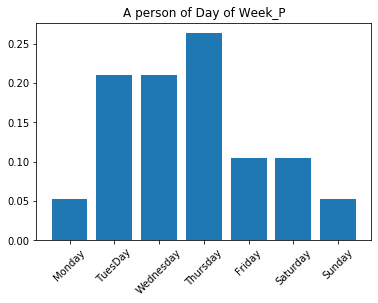



コマごとのくる確率: 

   1コマ目：17.0%
   2コマ目：4.2%
   3コマ目：8.5%
   4コマ目：0.0%
   5コマ目：0.0%
   6コマ目：5.0%
   7コマ目：17.8%
   8コマ目：29.7%
   9コマ目：17.8%


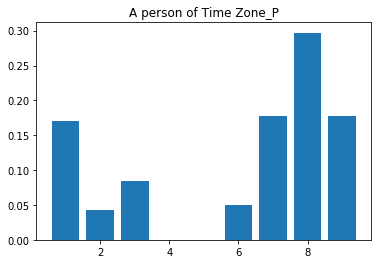



ステージごとのくる確率: 

   Beginner    ：10.1%
   Elementary  ：47.3%
   Intermediate：42.6%
   Advanced    ：0.0%


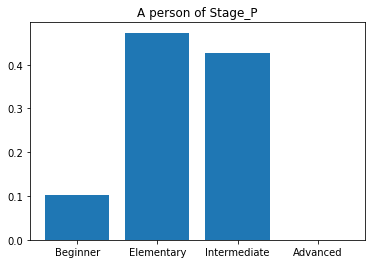

In [19]:
tmp_person = 0
print('ある生徒A(Name Label = 0)について\n')
print('生徒Aが1日に1回でも来る確率：{:.1f}% \n'.format(Students_P[tmp_person]['Come Up_P'][0]*100.0))
print('\n曜日ごとのくる確率: \n')
tmp_i = ['Monday','TuesDay','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    print('   {:10}：{:.1f}%'.format(tmp_i[i],Students_P[tmp_person]['Day of Week_P'][i]*100.0))


plt.bar(x=tmp_i,height=Students_P[tmp_person]['Day of Week_P'])
plt.title('A person of Day of Week_P')
plt.xticks(rotation=45)
plt.show()

    
print('\n\nコマごとのくる確率: \n')
tmp_i = [1,2,3,4,5,6,7,8,9]
for i in range(9):
    print('   {}コマ目：{:.1f}%'.format(tmp_i[i],Students_P[tmp_person]['Time Zone_P'][i]*100.0))

plt.bar(x=tmp_i,height=Students_P[tmp_person]['Time Zone_P'])
plt.title('A person of Time Zone_P')
plt.show()
    
print('\n\nステージごとのくる確率: \n')
tmp_i = ['Beginner','Elementary','Intermediate','Advanced']
for i in range(4):
    print('   {:12}：{:.1f}%'.format(tmp_i[i],Students_P[tmp_person]['Stage_P'][i]*100.0))
    
plt.bar(x=tmp_i,height=Students_P[tmp_person]['Stage_P'])
plt.title('A person of Stage_P')
plt.show()
    
del tmp_i

### 時間割のコマ、Stageごとの期待値を表す多次元配列 Cell_P をつくる

各コマごとの、より多くの生徒が来る期待値をヒートマップで表す。

期待値が高いほど赤、低いほど青で表す。



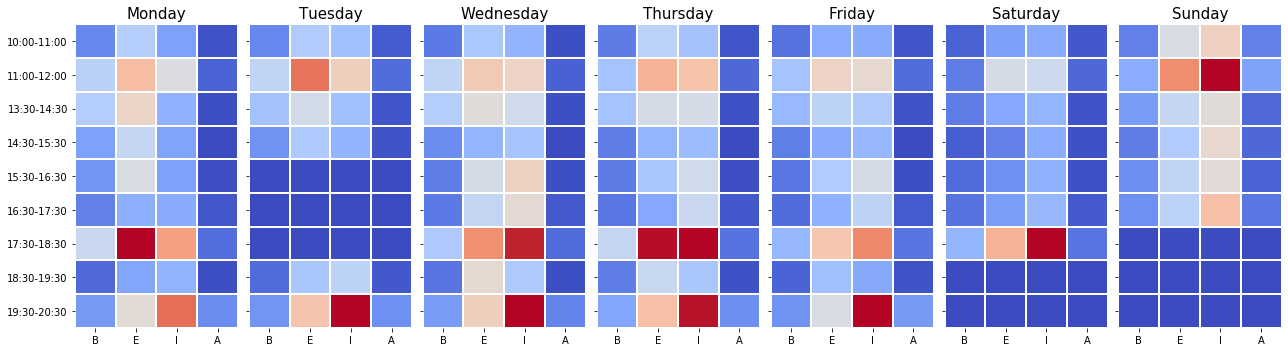

In [20]:
#[曜日][コマ][Stage]の(7,9,4)の辞書を作成する フラグ
Cell_P = np.zeros(7*9*4).reshape(7,9,4)

#月~日の9コマ分すべてのレッスンごと（初めて、初級、中級、中上級）の期待値を出してみる
for day in range(7):
    for zone in range(9):
        for stage in range(4):
            for name in range(31):
                Cell_P[day][zone][stage] += Students_P[name]['Come Up_P'][0]*Students_P[name]['Day of Week_P'][day]*Students_P[name]['Time Zone_P'][zone]*Students_P[name]['Stage_P'][stage]

#火曜5,6,7はジアン先生のレッスンが固定で入っている→確率はゼロに設定
Cell_P[1,4:7,:]=0.0
#土曜は8,9コマ目がない→確率はゼロに設定
Cell_P[5,7:9,:]=0.0
#日曜は7,8,9コマ目がない→確率はゼロに設定
Cell_P[6,6:9,:]=0.0

print('各コマごとの、より多くの生徒が来る期待値をヒートマップで表す。\n')
print('期待値が高いほど赤、低いほど青で表す。\n')
                
#各曜日、各コマ、各レッスンごとの生徒が来る確率をヒートマップで表す
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=1, ncols=7,sharey=True,figsize=(18,5))
sns.heatmap(Cell_P[0,:,:],ax=ax1,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax1.set_title('Monday',fontsize = 15)
sns.heatmap(Cell_P[1,:,:],ax=ax2,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax2.set_title('Tuesday',fontsize = 15)
sns.heatmap(Cell_P[2,:,:],ax=ax3,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax3.set_title('Wednesday',fontsize = 15)
sns.heatmap(Cell_P[3,:,:],ax=ax4,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax4.set_title('Thursday',fontsize = 15)
sns.heatmap(Cell_P[4,:,:],ax=ax5,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax5.set_title('Friday',fontsize = 15)
sns.heatmap(Cell_P[5,:,:],ax=ax6,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax6.set_title('Saturday',fontsize = 15)
sns.heatmap(Cell_P[6,:,:],ax=ax7,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax7.set_title('Sunday',fontsize = 15)
fig.tight_layout()
sns.set_context('poster')

plt.savefig('Distribution_All.png')

### レッスンのステージごとの生徒構成比を算出する

現在のステージ別構成比　Composition_of_Stage　を算出する



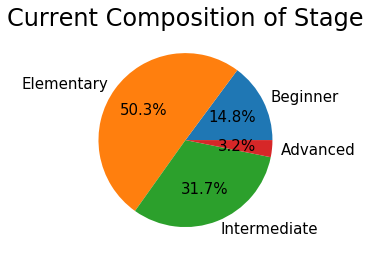

来月の目標とするステージ別構成比　Next_Composition_of_Stage　を算出する



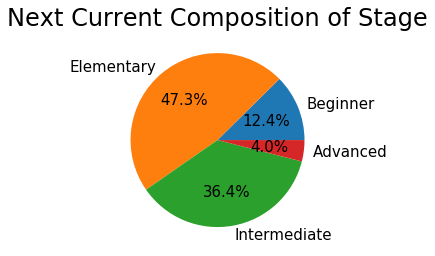




生徒のステージ別構成比をもとに、1週間の各レッスン数を算出する

Beginner    :5回
Elementary  :18回
Intermediate:14回
Advanced    :2回


In [21]:
print('現在のステージ別構成比　Composition_of_Stage　を算出する\n')
Composition_of_Stage= np.array([0.0,0.0,0.0,0.0])
for name in range(len(df['Name Label'].unique())):
    Composition_of_Stage += np.array(Students_P[name]['Stage_P'])
Composition_of_Stage = [n/sum(Composition_of_Stage) for n in Composition_of_Stage]

plt.title("Current Composition of Stage")
plt.rcParams['font.size'] = 30.0 
plt.pie(Composition_of_Stage, labels=['Beginner','Elementary','Intermediate','Advanced'],autopct='%1.1f%%',textprops={'fontsize': 15})
plt.savefig("Composition of Stage.png")
plt.show()


print('来月の目標とするステージ別構成比　Next_Composition_of_Stage　を算出する\n')
stretch = np.array([0.8,0.9,1.1,1.2])
Next_Composition_of_Stage = stretch * Composition_of_Stage
Next_Composition_of_Stage = [n/sum(Next_Composition_of_Stage) for n in Next_Composition_of_Stage]
plt.title("Next Current Composition of Stage")
plt.rcParams['font.size'] = 30.0 
plt.pie(Next_Composition_of_Stage, labels=['Beginner','Elementary','Intermediate','Advanced'],autopct='%1.1f%%',textprops={'fontsize': 15})
plt.savefig("Next_Composition_of_Stage.png")
plt.show()


Num_of_Lesson = [round(n*39) for n in Next_Composition_of_Stage]

print('\n\n\n生徒のステージ別構成比をもとに、1週間の各レッスン数を算出する\n')
tmp_i = ['Beginner','Elementary','Intermediate','Advanced']
for i in range(4):
    print('{:12}:{:.0f}回'.format(tmp_i[i],Num_of_Lesson[i]))

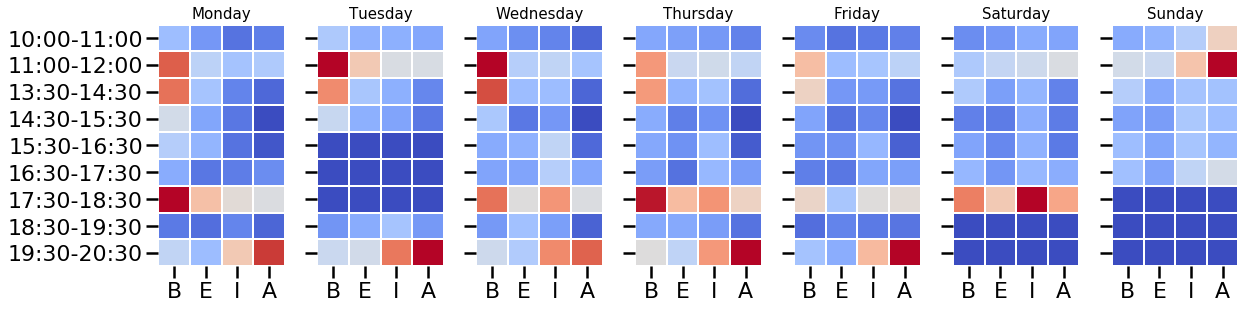

In [22]:

Cell_P[:,:,0] /= 5
Cell_P[:,:,1] /= 17
Cell_P[:,:,2] /= 15
Cell_P[:,:,3] /= 2


#各曜日、各コマ、各レッスンごとのコスパをヒートマップで表す
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=1, ncols=7,sharey=True,figsize=(18,5))
sns.heatmap(Cell_P[0,:,:],ax=ax1,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax1.set_title('Monday',fontsize = 15)
sns.heatmap(Cell_P[1,:,:],ax=ax2,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax2.set_title('Tuesday',fontsize = 15)
sns.heatmap(Cell_P[2,:,:],ax=ax3,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax3.set_title('Wednesday',fontsize = 15)
sns.heatmap(Cell_P[3,:,:],ax=ax4,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax4.set_title('Thursday',fontsize = 15)
sns.heatmap(Cell_P[4,:,:],ax=ax5,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax5.set_title('Friday',fontsize = 15)
sns.heatmap(Cell_P[5,:,:],ax=ax6,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax6.set_title('Saturday',fontsize = 15)
sns.heatmap(Cell_P[6,:,:],ax=ax7,linewidths=1, cmap='coolwarm', cbar=False, xticklabels=['B','E','I','A'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])
ax7.set_title('Sunday',fontsize = 15)
fig.tight_layout()
sns.set_context('poster')

plt.savefig('Distribution of Cost_Performance.png')

# 組み合わせ最適化問題を貪欲法（greedy）で近似解を求める

### 期待値が高いセルごとにソートする辞書のリスト CosPa　を作成

In [23]:
CosPa = [0]*7*9*4
for i in range(7*9*4):
    CosPa[i] = {
    'Value':0.0,
    'Day':0,
    'Zone':0,
    'Stage':0
}

cnt=0
for day in range(7):
    for zone in range(9):
        for stage in range(4):
            CosPa[cnt]['Value'] =Cell_P[day,zone,stage]
            CosPa[cnt]['Day'] = day
            CosPa[cnt]['Zone'] = zone
            CosPa[cnt]['Stage'] = stage
            cnt = cnt + 1
CosPa = sorted(CosPa, key=lambda x:x['Value'], reverse=True) 

print('貪欲法で解くために、期待値でソートされた以下のようなリストを作成する\n')
for i in range(10):
    print(CosPa[i])

#del Cell_P

貪欲法で解くために、期待値でソートされた以下のようなリストを作成する

{'Value': 0.014871377038563949, 'Day': 4, 'Zone': 8, 'Stage': 3}
{'Value': 0.01379192947817256, 'Day': 3, 'Zone': 8, 'Stage': 3}
{'Value': 0.013578757678027636, 'Day': 3, 'Zone': 6, 'Stage': 0}
{'Value': 0.013087700188240643, 'Day': 0, 'Zone': 6, 'Stage': 0}
{'Value': 0.012358455579244932, 'Day': 0, 'Zone': 8, 'Stage': 3}
{'Value': 0.012283149381058272, 'Day': 2, 'Zone': 1, 'Stage': 0}
{'Value': 0.011615397254139435, 'Day': 0, 'Zone': 1, 'Stage': 0}
{'Value': 0.011283023628753396, 'Day': 2, 'Zone': 2, 'Stage': 0}
{'Value': 0.011124899487896122, 'Day': 0, 'Zone': 2, 'Stage': 0}
{'Value': 0.010867747551027618, 'Day': 2, 'Zone': 8, 'Stage': 3}


### 時間割と対応させた多次元配列 Timetable に対し、Stage0,1,2,3のレッスンを割り当てる

In [24]:
def check(x):
    #条件を満たしているかチェックする関数 満たしていなければ１を、満たしていれば０を返す
    #Cospa[i]が引数
    
    #条件1：事前に決めた一週間のステージごとの総数を越えない
    val = 0
    if x['Stage']==0 and stage_cnt[0] >= Num_of_Lesson[0]: return 1
    elif x['Stage']==1 and stage_cnt[1] >= Num_of_Lesson[1]: return 1
    elif x['Stage']==2 and stage_cnt[2] >= Num_of_Lesson[2]: return 1
    elif x['Stage']==3 and stage_cnt[3] >= Num_of_Lesson[3]: return 1
    else: val = 0

    #条件２：前後で同じステージのレッスンが連続しない
    if x['Zone'] >= 1:
        if Timetable[x['Day'],x['Zone']-1, 1] == 1:
            if Timetable[x['Day'],x['Zone']-1, 0] == x['Stage']:
                return 1
    elif x['Zone'] <= 7:
        if Timetable[x['Day'],x['Zone']+1, 1] == 1:
            if Timetable[x['Day'],x['Zone']+1, 0] == x['Stage']:
                return 1
    else:
        val = 0
    
    #条件３：その他レッスン、FREEレッスンが最低でも一日に一つずつ含まれる
    if get_empty(x['Day']) >= 3:
        val = 0
    else:
        return 1
    return val

def get_empty(day):
    #曜日を表す引数dayをもとに、曜日ごとのTimetableで未決定セル数を返す
    cnt = 0
    for i in range(9):
        if Timetable[day,i,1] == 0 :
            cnt += 1
    return cnt

def stage_count(x):
    if x==0: stage_cnt[0] += 1
    elif x==1: stage_cnt[1] += 1
    elif x==2: stage_cnt[2] += 1
    elif x==3: stage_cnt[3] += 1

        
Timetable = np.array([0]*7*9*2) .reshape(7,9,2)
#火曜5,6,7はジアン先生のレッスンが固定で入っているので、フラグをたてておく
Timetable[1,4:7,1]=1
#土曜は8,9コマ目がない
Timetable[5,7:9,1]=1
#日曜は7,8,9コマ目がない
Timetable[6,6:9,1]=1

#貪欲法を用いてStage0,1,2,3のレッスンを割り当てる
cnt = 7*9
stage_cnt = [0,0,0,0]
for i in range(len(CosPa)):
    if Timetable[CosPa[i]['Day']][CosPa[i]['Zone']][1] != 1:
        if check(CosPa[i]) == 0 :
            Timetable[CosPa[i]['Day']][CosPa[i]['Zone']][0] = CosPa[i]['Stage']
            Timetable[CosPa[i]['Day']][CosPa[i]['Zone']][1] = 1
            cnt = cnt-1
            stage_count(CosPa[i]['Stage'])
        if cnt == 0 :
            break

#火曜5,6,7はジアン先生のレッスンが固定で入っている
Timetable[1,4:7,0]=-1
#土曜は8,9コマ目がない
Timetable[5,7:9,0]=-1
#日曜は7,8,9コマ目がない
Timetable[6,6:9,0]=-1

### 一日の中で未決定セルのうち、期待値が最も高いセルにFREEレッスンを、それ以外にその他レッスンを割り当てる
### ただし、FREEレッスンを割り当てる際、その他レッスンが連続しないことを優先する

In [25]:
tmp0 = np.zeros(7*9).reshape(7,9)
tmp0 = [[sum(Cell_P[day,zone,:]) if Timetable[day,zone,1]==0 else 0.0 for zone in range(9) ] for day in range(7)]

#未決定セル（flag=0）のなかで最も期待値の高いセルをfree_zoneに代入する
free_zone = np.zeros(7)
for day in range(7):
    tmp_max = 0
    for zone in range(9):
        if tmp_max < tmp0[day][zone]:
            tmp_max = tmp0[day][zone]
            free_zone[day] = zone
            
#未決定セルのなかで、期待値が最も高いセルにFREEレッスンを、それ以外にその他レッスンを割り当てる
for day in range(7):
    Timetable[day,int(free_zone[day]),0] = 4
    Timetable[day,int(free_zone[day]),1] = 1
    for zone in range(9):
        if Timetable[day,zone,1]==0:
            Timetable[day,zone,0] = 5
            Timetable[day,zone,1] = 1


# 算出した時間割をグラフ描画
### グラフのラベルについて
- None : このコマにはレッスンが入らない
- B : Beginner の頭文字。初めて英語クラス
- E : Elementary の頭文字。初級クラス
- I : Intermediate の頭文字。中級クラス
- A : Advanced の頭文字。中上級クラス

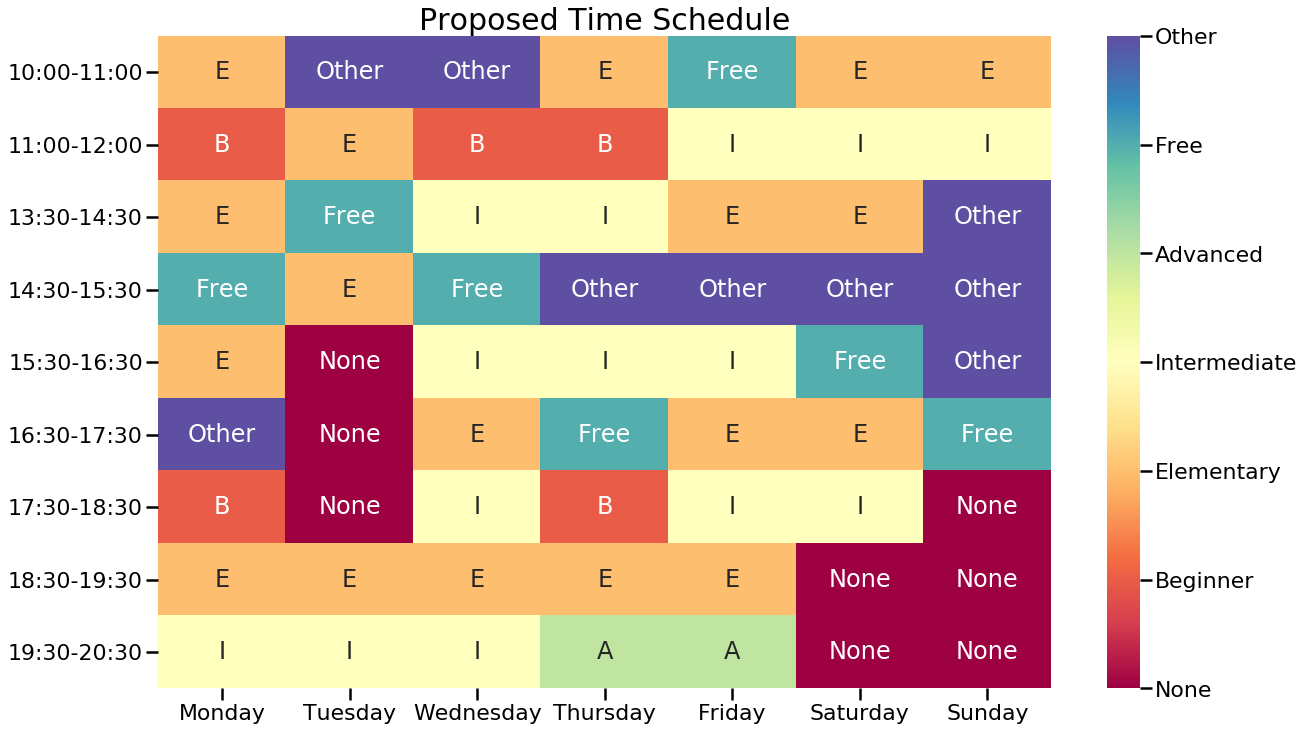

In [26]:
#ラベルの作成
labels = np.asarray(['abcde']*7*9).reshape(7,9)
for day in range(7):
    for zone in range(9):
        if Timetable[day,zone,0] == -1:
            labels[day][zone] = 'None'
        elif Timetable[day,zone,0] == 0:
            labels[day][zone] = 'B'
        elif Timetable[day,zone,0] == 1:
            labels[day][zone] = 'E'
        elif Timetable[day,zone,0] == 2:
            labels[day][zone] = 'I'
        elif Timetable[day,zone,0] == 3:
            labels[day][zone] = 'A'
        elif Timetable[day,zone,0] == 4:
            labels[day][zone] = 'Free'
        elif Timetable[day,zone,0] == 5:
            labels[day][zone] = 'Other'
labels = labels.T


#グラフの作成
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,12))
data = Timetable[:,:,0].T
ax.set_title('Proposed Time Schedule',fontsize = 30)
sns.heatmap(data, annot=labels, fmt="", cmap='Spectral', xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],yticklabels=['10:00-11:00','11:00-12:00','13:30-14:30','14:30-15:30','15:30-16:30','16:30-17:30','17:30-18:30','18:30-19:30','19:30-20:30'])

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([5,4,3,2,1,0,-1])
colorbar.set_ticklabels(['Other', 'Free', 'Advanced','Intermediate','Elementary','Beginner','None'])
plt.savefig('Proposed Time Schedule.png')